### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import albumentations as A
# from torchvision import datasets, transforms
import importlib
from torch_lr_finder import LRFinder
from utils import utils
from utils.utils import fabric
from utils.dataset import Dataset
from utils.scheduler import Scheduler
import warnings

warnings.filterwarnings('ignore')

Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [2]:
# Initialize
utils.set_seed(1)

### Import dataset: CIFAR10

In [3]:
dataset = Dataset('CIFAR10', batch_size=512, trans_lib='albumentations')
print(dataset.dt.mean)
# Add augmentations for training dataset
dataset.dt.set_transforms('train', [
    A.PadIfNeeded(min_height=40, min_width=40), #, always_apply=True
    A.RandomCrop(height=32, width=32), # , always_apply=True
    A.HorizontalFlip(),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=dataset.dt.mean)
], True)

Files already downloaded and verified
Files already downloaded and verified
The mean and SD for CIFAR10 dataset are [0.49139968 0.48215841 0.44653091] and [0.24703223 0.24348513 0.26158784] respectively.
Files already downloaded and verified
Files already downloaded and verified
(0.4913996786152028, 0.4821584083946074, 0.4465309144454644)


In [4]:
train_loader, test_loader = dataset.get_data_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# from torchvision.datasets import CIFAR10
# from utils.dataset_override import CIFAR10_Override
# from albumentations.pytorch import ToTensorV2
# import numpy as np
# means = [0.4914, 0.4822, 0.4465]
# stds = [0.2470, 0.2435, 0.2616]

# m = np.array(means)*255
# train_transforms = A.Compose([
#     A.Normalize(mean=means, std=stds, always_apply=True),
#     A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
#     A.RandomCrop(height=32, width=32, always_apply=True),
#     A.HorizontalFlip(),
#     A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
#     ToTensorV2()
# ])
# train = CIFAR10_Override('../data', train=True, download=True, transform=train_transforms)
# train.trans_lib = 'albumentations'
# dataloader_cfgs = {
#     'batch_size': 512,
#     'shuffle': True,
#     'num_workers': 4,
#     'pin_memory': True
# }
# train_loader = torch.utils.data.DataLoader(train, **dataloader_cfgs)

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
# images.shape, labels.shape
torch.mean(images), torch.std(images), torch.min(images), torch.max(images)

(tensor(0.0366), tensor(0.9997), tensor(-1.9892), tensor(2.1268))

### Visualize input images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

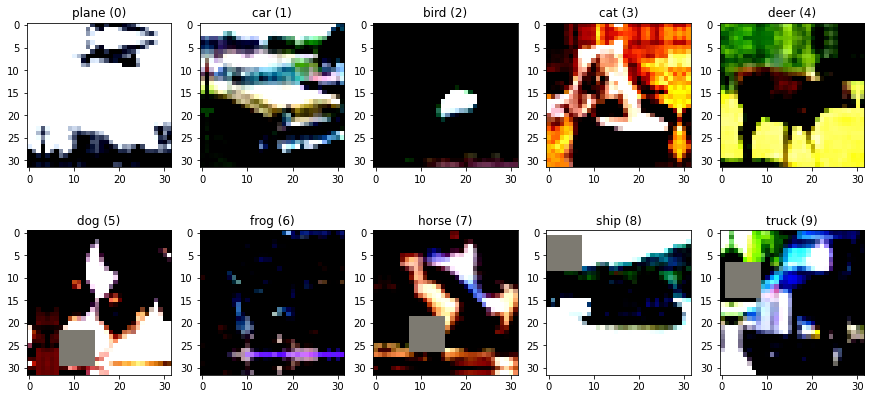

In [7]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# images, labels = next(dataiter)
utils.visualize_images(images, labels, label_mapper, n_cols=5, figsize=(15, 7))

### Model Training

In [8]:
from models import custom_resnet
importlib.reload(custom_resnet)

<module 'models.custom_resnet' from 'd:\\Self Learning\\TSAI\\TSAI\\S10\\models\\custom_resnet.py'>

In [9]:
from models.custom_resnet import CustomResNet
device = utils.get_device()
in_ch = 3
model_1 = CustomResNet(in_ch=in_ch).to(device)
summary(model_1, input_size=(in_ch, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

### LR Finder

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.70E-02


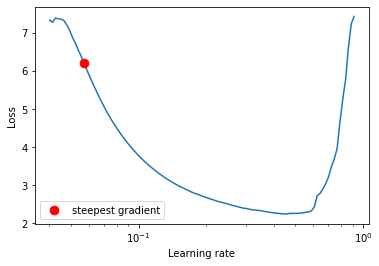

In [10]:
model = CustomResNet(in_ch=in_ch).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [12]:
num_epochs = 24
max_lr = 5.70E-02
steps_per_epoch = len(train_loader)

scheduler = Scheduler('OneCycleLR', {
    'optimizer': optimizer,
    'max_lr': max_lr,
    'steps_per_epoch': steps_per_epoch, 
    'epochs': num_epochs, 
    'pct_start': 5/num_epochs,
    'div_factor': 100,
    'final_div_factor': 100,
    'three_phase': False,
    'anneal_strategy': 'linear',
    'verbose': False
})

for epoch in range(1, num_epochs+1):
    print('EPOCH:', epoch)
    model.model_train(device, train_loader, criterion, optimizer, scheduler)
    model.model_test(device, test_loader, criterion)

EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss=1.1754361391067505 Batch_id=97 Accuracy=50.36: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s]


Test: Average loss: 0.0025, Accuracy: 5774/10000 (57.74%), Accuracy Diff: 7.38

EPOCH: 2


Train: Loss=1.01460862159729 Batch_id=97 Accuracy=64.13: 100%|██████████| 98/98 [00:45<00:00,  2.15it/s]  


Test: Average loss: 0.0019, Accuracy: 6874/10000 (68.74%), Accuracy Diff: 4.614

EPOCH: 3


Train: Loss=0.7016140818595886 Batch_id=97 Accuracy=71.07: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]


Test: Average loss: 0.0023, Accuracy: 6399/10000 (63.99%), Accuracy Diff: 7.082

EPOCH: 4


Train: Loss=0.778441309928894 Batch_id=97 Accuracy=74.24: 100%|██████████| 98/98 [00:46<00:00,  2.13it/s] 


Test: Average loss: 0.0023, Accuracy: 6273/10000 (62.73%), Accuracy Diff: 11.51

EPOCH: 5


Train: Loss=0.8254714012145996 Batch_id=97 Accuracy=74.34: 100%|██████████| 98/98 [00:45<00:00,  2.15it/s]


Test: Average loss: 0.0019, Accuracy: 6849/10000 (68.49%), Accuracy Diff: 5.85

EPOCH: 6


Train: Loss=0.7321280837059021 Batch_id=97 Accuracy=74.45: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]


Test: Average loss: 0.0023, Accuracy: 6102/10000 (61.02%), Accuracy Diff: 13.434

EPOCH: 7


Train: Loss=0.8000051379203796 Batch_id=97 Accuracy=75.84: 100%|██████████| 98/98 [00:45<00:00,  2.17it/s]


Test: Average loss: 0.0017, Accuracy: 7190/10000 (71.90%), Accuracy Diff: 3.938

EPOCH: 8


Train: Loss=0.7351503968238831 Batch_id=97 Accuracy=75.73: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]


Test: Average loss: 0.0016, Accuracy: 7257/10000 (72.57%), Accuracy Diff: 3.164

EPOCH: 9


Train: Loss=0.6041923761367798 Batch_id=97 Accuracy=76.08: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test: Average loss: 0.0016, Accuracy: 7131/10000 (71.31%), Accuracy Diff: 4.77

EPOCH: 10


Train: Loss=0.6428808569908142 Batch_id=97 Accuracy=76.46: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Test: Average loss: 0.0016, Accuracy: 7288/10000 (72.88%), Accuracy Diff: 3.584

EPOCH: 11


Train: Loss=0.7463566660881042 Batch_id=97 Accuracy=76.99: 100%|██████████| 98/98 [00:49<00:00,  1.96it/s]


Test: Average loss: 0.0014, Accuracy: 7487/10000 (74.87%), Accuracy Diff: 2.124

EPOCH: 12


Train: Loss=0.6708360314369202 Batch_id=97 Accuracy=77.58: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test: Average loss: 0.0016, Accuracy: 7307/10000 (73.07%), Accuracy Diff: 4.508

EPOCH: 13


Train: Loss=0.6872654557228088 Batch_id=97 Accuracy=77.99: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Test: Average loss: 0.0016, Accuracy: 7304/10000 (73.04%), Accuracy Diff: 4.948

EPOCH: 14


Train: Loss=0.6101414561271667 Batch_id=97 Accuracy=78.49: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s]


Test: Average loss: 0.0014, Accuracy: 7567/10000 (75.67%), Accuracy Diff: 2.824

EPOCH: 15


Train: Loss=0.5986323356628418 Batch_id=97 Accuracy=79.00: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s] 


Test: Average loss: 0.0013, Accuracy: 7797/10000 (77.97%), Accuracy Diff: 1.028

EPOCH: 16


Train: Loss=0.5429795980453491 Batch_id=97 Accuracy=79.80: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s] 


Test: Average loss: 0.0019, Accuracy: 6720/10000 (67.20%), Accuracy Diff: 12.604

EPOCH: 17


Train: Loss=0.6509968638420105 Batch_id=97 Accuracy=80.85: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s] 


Test: Average loss: 0.0017, Accuracy: 7203/10000 (72.03%), Accuracy Diff: 8.822

EPOCH: 18


Train: Loss=0.5649927258491516 Batch_id=97 Accuracy=81.30: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s] 


Test: Average loss: 0.0011, Accuracy: 8166/10000 (81.66%), Accuracy Diff: 0.356

EPOCH: 19


Train: Loss=0.6859863996505737 Batch_id=97 Accuracy=82.79: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s] 


Test: Average loss: 0.0010, Accuracy: 8317/10000 (83.17%), Accuracy Diff: 0.384

EPOCH: 20


Train: Loss=0.5248984098434448 Batch_id=97 Accuracy=83.92: 100%|██████████| 98/98 [00:45<00:00,  2.13it/s] 


Test: Average loss: 0.0010, Accuracy: 8274/10000 (82.74%), Accuracy Diff: 1.182

EPOCH: 21


Train: Loss=0.40495622158050537 Batch_id=97 Accuracy=85.37: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]


Test: Average loss: 0.0009, Accuracy: 8522/10000 (85.22%), Accuracy Diff: 0.148

EPOCH: 22


Train: Loss=0.41047313809394836 Batch_id=97 Accuracy=86.59: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]


Test: Average loss: 0.0008, Accuracy: 8613/10000 (86.13%), Accuracy Diff: 0.456

EPOCH: 23


Train: Loss=0.32929834723472595 Batch_id=97 Accuracy=88.78: 100%|██████████| 98/98 [00:51<00:00,  1.89it/s]


Test: Average loss: 0.0006, Accuracy: 8932/10000 (89.32%), Accuracy Diff: 0.536

EPOCH: 24


Train: Loss=0.24733813107013702 Batch_id=97 Accuracy=90.74: 100%|██████████| 98/98 [00:54<00:00,  1.79it/s]


Test: Average loss: 0.0006, Accuracy: 9015/10000 (90.15%), Accuracy Diff: 0.588



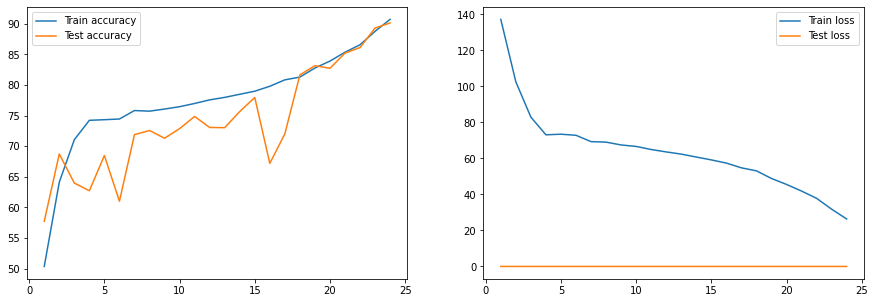

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
model.plot_accuracy()
plt.subplot(122)
model.plot_loss()
# plt.savefig('images/model.png')
plt.show()

In [14]:
max(model.train_accuracy), max(model.test_accuracy)

(90.738, 90.15)

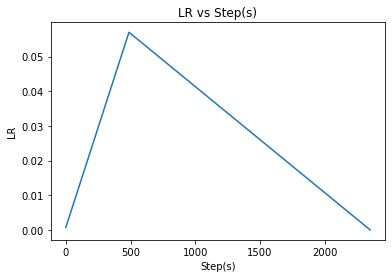

In [15]:
scheduler.plot_lr_change()

### Visualizing incorrect predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

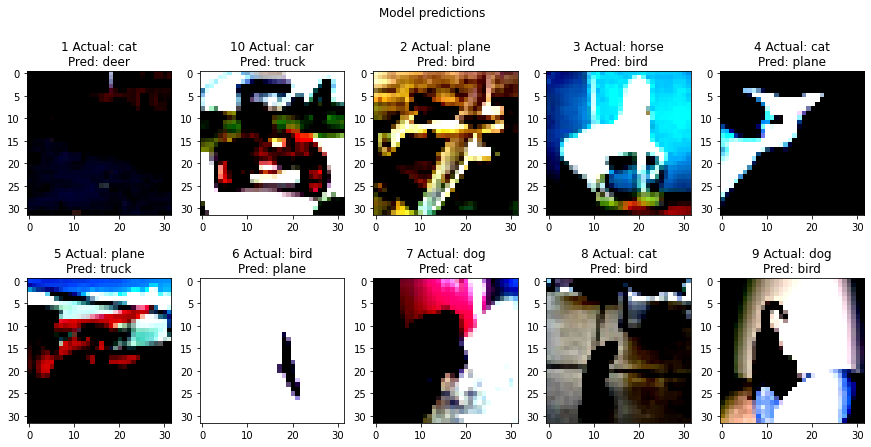

In [16]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images, actual, pred = model.get_incorrect_pred(device, test_loader)
images, actual, pred = images.to('cpu'), actual.to('cpu'), pred.to('cpu')
labels = [str(indx + 1) + ' Actual: %s' % label_mapper[act.item()] + '\n' + \
    'Pred: %s' % label_mapper[pr.item()] for indx, (act, pr) in enumerate(zip(actual, pred))]
utils.visualize_images(images, labels, n_cols=5, figsize=(15, 7), img_title='Model predictions')